In [ ]:
# %% Import Statements
import copy
import math
import random
import numpy as np
from PIL import Image
from operator import itemgetter
import matplotlib.pyplot as plt
from collections import defaultdict
from scipy.optimize import curve_fit

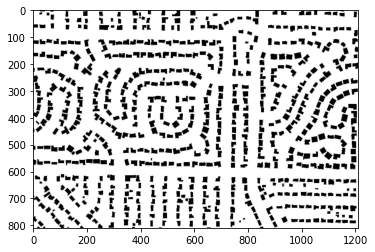

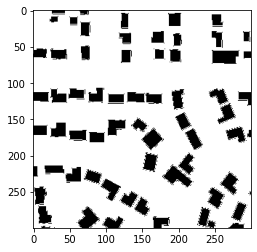

1.0


In [ ]:
# %% Map Construction
map = np.zeros((810, 1210))
for i in range(10):
    for j in range(10):
        img_name = 'row-' + str(i+1) + '-column-' + str(j+1) + '.png'
        img = Image.open(img_name)
        img = img.convert('L')
        img = np.asarray(img) / 255
        map[81*i:81*(i+1), 121*j:121*(j+1)] = img[0:81, 0:121]

# Display the original map
plt.imshow(map,plt.cm.gray)
plt.show()

# Display the map used for the project
map = map[:300,:300]
plt.imshow(map,plt.cm.gray)
plt.show()

# Verify that sink node is unobstructed
print(map[149,150]) 

In [ ]:
# %% Graph Class
class Graph:
    # Constructor method
    def __init__(self):
        # Define data structures to hold graph information
        self.graph = np.zeros((1000, 1000)) # Residual matrix for 1000 nodes
        self.graph2 = [i[:] for i in self.graph] # Copy of residual matrix
        self.nodes = defaultdict(tuple) # nodes[i] = (r, c)
        self.reverse_nodes = defaultdict(lambda:-1) # reverse_nodes[(r, c)] = i
        self.count = 0 # Keeps track of node number
        self.edges = [] # Stores all node edges
        
        # Sink node initialization
        sink = (math.floor(300 / 2), math.floor(300 / 2))
        self.add_node_edge(sink, None)
        self.sp_tree = defaultdict(int) # Spanning tree for check purposes

    # Redefine spanning tree
    def set_sp_tree(self, tree):
        self.sp_tree = tree

    # Add element to spanning tree
    def add_tree(self, tup, val):
        self.sp_tree[tup] = val

    # Return spanning tree
    def ret_tree(self):
        return self.sp_tree
    
    # Return all nodes' coordinates
    def get_nodes(self):
        return self.nodes

    # Return all nodes' numbers
    def get__reverse_nodes(self):
        return self.reverse_nodes

    # Add node with edge to graph
    def add_node_edge(self, node, prev_node, weight=1):
        '''
        Adds node 'node' to the graph, connecting it to node 'prev_node' with a 
        single edge. If 'prev_node' is absent, no edge is added. The default 
        edge weight is determined to be unit value (i.e. 1).

        Inputs:
            - node -> tuple (row, column)
            - prev_node -> tuple (row, column)
        '''

        # Add node to the graph
        self.nodes[self.count] = node
        self.reverse_nodes[node] = self.count
        
        # If necessary add edge
        if (prev_node != None): 
            i = self.reverse_nodes[node]
            j = self.reverse_nodes[prev_node]
            self.graph[i][j] = weight
            self.graph[j][i] = weight
            self.edges.append(str(i) + " -> " + str(j))
            self.edges.append(str(j) + " -> " + str(i))
            
        self.count += 1

    # Add edge between two existing nodes
    def add_edge(self, node1, node2, weight=1):
        '''
        Adds edge from node 'node1' to node 'node2' with a single edge. The 
        default edge weight is determined to be unit value (i.e. 1). It is 
        assumed that both nodes currently exist in the graph. 

        Inputs:
            - node1 -> tuple (row, column)
            - node2 -> tuple (row, column)
        '''

        i = self.reverse_nodes[node1]
        j = self.reverse_nodes[node2]
        self.graph[i][j] = weight
        self.graph[j][i] = weight
        self.edges.append(str(i) + " -> " + str(j))
        self.edges.append(str(j) + " -> " + str(i))
        
    # Displays entirety of graph
    def display_graph(self):
        print("Graph with node count:", str(self.count + 1))
        print(self.nodes)
        print("Below is the edge adjacency matrix:")
        print(self.graph)
        
        # Print out list of edges
        print("Below is the list of graph edges:")
        for e in self.edges:
            print(e)

    # Returns max spanning tree in dictionary representation
    def max_span(self):
        '''
        Finds the maximum spanning tree for the graph G, returning the result in
        the form of a dictionary. 

        Outputs:
            - tree_dic -> dictionary (key=(node1, node2), val=n1n2 edge weight)
        '''

        # Initialize max spanning tree
        tree_dic = defaultdict(int)

        # Stores parent nodes, tracks whether node is traversed, and weights
        beg, check, connect = np.zeros(len(self.nodes)), np.zeros(len(self.nodes)), np.zeros(len(self.nodes))

        for i in range(len(self.nodes) - 1):
            # Find the maximum weight index
            wsf, ind = -1, None # wsf -> weight so far

            for k in range(len(self.nodes)):
                if (check[k] == 0 and connect[k] > wsf):
                    wsf = connect[k]
                    ind = k
            
            check[ind] = 1 # Set node traversal

            for l in range(len(self.nodes)):
                if (check[l] == 0 and self.graph[l, ind] > connect[l]):
                    connect[l] = self.graph[l, ind]
                    beg[l] = ind
            
        # Fill out spanning tree
        for i in range(len(self.nodes) - 1):
            tree_dic[(int(beg[i+1]), i+1)] = self.graph[i+1, int(beg[i+1])]
        
        return tree_dic

    # Returns the mincut from the spanning tree
    def min_cut(self, s, d, max_sp):
        '''
        Finds the minimum cut for the graph G from the spanning tree. The inputs
        's' and 'd' are both node numbers, NOT node map coordinates.

        Inputs:
            - s -> int
            - d -> int

        Outputs:
            - min(all_weight) -> float
        '''

        # Store dictionary mapping node tuples to weights
        sp = max_sp
        p = list(sp.keys())

        # Store dictionary mapping children to parents
        c_to_p = defaultdict(int) 

        for i in p:
            c_to_p[i[1]] = i[0]

        # Find the source to root path
        s_path = []
        s1 = s

        # Walk backwards from children to its parent until it encounters 0
        while True:
            s_path.append(s1)
            if (s1 == 0): break
            else:
                if (c_to_p[s1] == 0):
                    s_path.append(0)
                    break
                else: s1 = c_to_p[s1]

        # Likewise, find drain to root path
        d_path = []
        d1 = d

        # Walk backwards from children to its parent, until it encounters 0
        while True:
            d_path.append(d1)
            if d1 == 0:
                break
            else:
                if c_to_p[d1] == 0:
                    d_path.append(0)
                    break
                else:
                    d1 = c_to_p[d1]

        # Utilizing both paths, find the first matching element
        # This node is where we truncate the route (it's out 'connecting node')
        i_ind = 0

        for i in s_path:
            j_ind = 0

            for j in d_path:
                if i == j: break
                j_ind += 1

            if i == j: break
            i_ind += 1
      
        # Truncate routes after first identical node
        s_path = s_path[:i_ind+1]
        d_path = d_path[:j_ind+1]

        # Get all tuples of (parent, child) to get weight from max spanning tree
        all_tup = []

        for i in range(len(s_path)-1):
            all_tup.append((s_path[i+1], s_path[i]))
        for i in range(len(d_path)-1):
            all_tup.append((d_path[i+1], d_path[i]))
        
        # Get all weights from max spanning tree and return mincut
        all_weight = []

        for k in all_tup:
            all_weight.append(sp[k])

        return min(all_weight)

    # Returns the worst multi-cut
    def worst_mult_cut(self, sp):
        '''
        Finds the worst multi-cut for the graph G from the spanning tree.

        Outputs:
            - min(multi_cast_arr) -> float
        '''

        # Find all paths for a node to reach sink and count occurances of node
        c_to_p = defaultdict(int)
        p = list(sp.keys())

        for i in p:
            c_to_p[i[1]] = i[0]

        all_path = defaultdict(list)
        for i in range(1, len(self.get_nodes())):
            s_path = []
            s1 = i

            # Walk back from children to its parent until it encounters 0
            while True:
                s_path.append(s1)
                if (s1 == 0): break
                else:
                    if (c_to_p[s1] == 0):
                        s_path.append(0)
                        break
                    else: s1 = c_to_p[s1]

            all_path[i] = s_path

        # Count children of node (including itself)
        set_count = defaultdict(int)

        for i in range(len(self.get_nodes())):
            for k in all_path.keys():
                if (i in all_path[k]): set_count[i] += 1
        
        multi_cast_arr = []

        for i in set_count.keys():
            if (set_count[i] != 0 and i != 0):
                multi_cast_arr.append(self.min_cut(i, 0, sp) / set_count[i])
        return min(multi_cast_arr)

In [ ]:
# %% Utility Functions

# Defines function required for curve_fit
def fit_line(x, m, b):
    return m*x + b

# Check for obstruction between both sensors, if obstructed return True
def check_obstruction(coord1, coord2, map):
    if (coord1[1] == coord2[1]): # For sensors on the same vertical line
        temp = map[min(coord1[0], coord2[0])+1:max(coord1[0],coord2[0]), coord1[1]]
        if (0 in temp): return True
        else: return False
    elif (coord1[0] == coord2[0]): # For sensors on the same horizontal line
        temp = map[coord1[0], min(coord1[1], coord2[1])+1:max(coord1[1], coord2[1])]
        if (0 in temp): return True
        else: return False

    # Get line passing through both sensors
    popt, pcov = curve_fit(fit_line,[coord1[1], coord2[1]], [coord1[0], coord2[0]])

    # If slope < 45 degrees, loop through x getting floor of y values
    if (abs(popt[0]) <= 1):
        for i in range(min(coord1[1],coord2[1]), max(coord1[1],coord2[1])):
            if map[int(fit_line(i+0.5,*popt)), i] == 0:
                return True
    # If slope > 45 degrees, loop through y getting floor of x values
    else: 
        for i in range(min(coord1[0], coord2[0]), max(coord1[0], coord2[0])):
            if (map[i, int((i + 0.5 - popt[1]) / popt[0])] == 0):
                return True

    return False

# Calculate the communication rate between two sensors
def comm_rate(coord1, coord2, map):
    dist = math.sqrt((coord1[0]-coord2[0])**2 + (coord1[1]-coord2[1])**2)
    if (check_obstruction(coord1, coord2, map)):
        return math.log(1 + 10**4/max(1, dist**4), 2)
    else:
        return math.log(1 + 10**4/max(1, dist**2), 2)


In [ ]:
# %% Sensor Network Methods

# Add a set amount of nodes to our network
def add_nodes(G, n_nodes, map, sensor_map):
    '''
        Adds a certain amount of nodes to the sensor network. Note that for our
        use case, it is more appropriate to call this function in a loop, with
        this functioning as essentially driver code for the add_one_node method.
        The sensor_map is a copy of map, but notes which cells are 'covered' by
        other sensors. It is used in the node placement algorithm. 

        Inputs:
            - G -> Graph class object
            - n_nodes -> int 
            - map -> numpy ndarray
            - sensor_map -> numpy ndarray

        Outputs:
            - connectivity -> list
            - coverage -> float
    '''

    if (n_nodes <= 0): return

    # Store unobstructed coordinates
    total_free = 0
    coord_free = []

    for r in range(300):
        for c in range(300):
            if (map[r, c] == 1): 
                coord_free.append((r, c))
                total_free += 1

    #add n nodes to the graph
    all_el = list(G.get_nodes().values())

    for i in range(n_nodes):
        add_one_node(G, map, sensor_map)

    worst_cut = 1000
    ave_cut = 0
    mult_cut = 1000

    all_coord = list(G.get_nodes().values())

    
    # Calculate max spanning tree every 20 nodes
    if ((len(G.get_nodes()) % 20 == 0) or (len(G.get_nodes()) == 2)):
        print("----- CALCULATING MAX SPANNING TREE -----")
        count = 1
        all_reverse = G.get__reverse_nodes()
        m_sp_t = G.max_span()
        G.set_sp_tree(m_sp_t)

        for i in all_coord[1:]:
            for j in all_coord[1:]:
                num1 = all_reverse[i]
                num2 = all_reverse[j]

                if (i != j):
                    m_cut = G.min_cut(num1,num2,m_sp_t)
                    ave_cut += m_cut
                    if (m_cut < worst_cut): worst_cut = m_cut
                    count += 1
        
        mult_cut = G.worst_mult_cut(m_sp_t)
        ave_cut = ave_cut/count

    # Calculate connectivity
    connectivity = [worst_cut,ave_cut,mult_cut]

    # Calculate coverage
    map2 = copy.deepcopy(map)
    for n in all_coord:
        r = n[0]
        c = n[1]
        if (r < 0 or c < 0): print("Warning: r =", str(r), ", c =", str(c))
        map2[max(r-4, 0):min(r+5, 299), max(c-4, 0):min(c+5, 299)] = np.zeros((min(r+5, 299) - max(r-4, 0), min(c+5, 299) - max(c-4, 0)))

    new_free = 0
    for r in range(300):
        for c in range(300):
            if (map2[r, c] == 1): new_free += 1
    
    coverage = float(total_free - new_free) / total_free

    return (connectivity, coverage)

# Adds node to sensor network via node placement algorithm
def add_one_node(G, map, sensor_map):
    '''
    Adds a single node to our node network utilizing our placement algorithm,
    which involves a waterfall thresholding approach, and correlating to a 
    decision gradient from algorithmic to random placement. We attempt to find a
    suitable location through our highest threshold first, then the next highest
    threshold if available, then the lowest threshold if available, and finally
    to a completely random placement if no thresholds are met. Additionally, to
    improve connectivity, an anchor node is chosen, such that the new node is 
    guaranteed to be within a certain range of this anchor node (to avoid the
    situation where a new node is placed completely away from the rest of the 
    network).

    Inputs:
        - G -> Graph class object
        - map -> numpy ndarray
        - sensor_map -> numpy ndarray

    Outputs:
        - loc -> tuple (row, column)
    '''

    # Update the sink node and coverage appropriately
    if (len(G.get_nodes()) == 1):
        update_graph(G, (150, 149), map)

        r = 146 # 150 - 4
        c = 145 # 149 - 4

        # Mark the sensor coverage
        for i in range(r, r+9):
            for j in range(c, c+9):
                sensor_map[i][j] = 0
        return

    # Find our anchor node to connect new node to
    nodes = G.get_nodes()
    anchor = list(nodes)[random.randint(0, len(list(G.get_nodes()))-1)] # DELTA DELTA list(G.get_nodes())
    anchor = nodes[anchor]

    anchor_r = anchor[0] # row coordinate
    anchor_c = anchor[1] # column coordinate

    # Define waterfall algorithm thresholds
    threshold = 0.95 # 95% of optimal coverage (i.e. 95% of 81 coverage)
    threshold2 = 0.70 # 70% of optimal coverage
    threshold3 = 0.55 # 55% of optimal coverage

    choice_coord = [] # List to choose optimal choice from multiple options
    free_space = 0
    base = None # New node location
    added = False

    # Loop through a specified range square to find optimal location, if exists
    for i in range(max(anchor_r-9, 0), min(anchor_r+10, 300)):
        for j in range(max(anchor_c-9, 0), min(anchor_c+10, 300)):
            free_space = sum([np.count_nonzero(x == 1) for x in sensor_map[i-4:i+5, j-4:j+5]])
            if (free_space >= int(threshold * 81) and map[i][j] == 1):
                # print("This is our threshold: ", str(int(threshold * 81)))
                # print("This is the free space: ", str(free_space))
                loc = base = (i, j)
                update_graph(G, loc, map)
                added = True
                break
        if (added): break
  
    # Second waterfall tier: execute placement via secondary threshold
    count = 0
    while (not added and (count < 30)):
        # print("Made it into secondary choice!")

        # Repeat the process above for a new anchor
        anchor = list(G.get_nodes())[random.randint(0, len(list(G.get_nodes()))-1)]
        anchor = nodes[anchor]
        anchor_r = anchor[0] # row coordinate
        anchor_c = anchor[1] # column coordinate

        for i in range(max(anchor_r-9, 0), min(anchor_r+10, 300)):
            for j in range(max(anchor_c-9, 0), min(anchor_c+10, 300)):
                free_space = sum([np.count_nonzero(x == 1) for x in sensor_map[i-4:i+5, j-4:j+5]])
                if (free_space >= int(threshold2 * 81) and map[i][j] == 1):
                    # print("This is our secondary threshold: ", str(int(threshold2 * 81)))
                    # print("This is the secondary free space: ", str(free_space))

                    # Add new node location option to list of options
                    choice_coord.append(((i, j), free_space))
                    
                    # Break if we have 3 or more placement options
                    if (len(choice_coord) > 2):
                        added = True
                        break
            if (added): break

        # Find optimal placement option, covers edge case if only 1 or 2 options
        if (len(choice_coord) > 0):
            added = True
            loc = base = max(choice_coord, key=itemgetter(1))[0]
            update_graph(G, loc, map)

        # Increment counter, ensures we exit out of infinite loop
        count += 1
        
    # Third waterfall tier: execute semi-random placement via third threshold
    if (not added):
        # print("Partly random!")

        # Repeat the process above for a new anchor
        anchor = list(G.get_nodes())[random.randint(0, len(list(G.get_nodes()))-1)]
        anchor = nodes[anchor]
        anchor_r = anchor[0] # row coordinate
        anchor_c = anchor[1] # column coordinate

        # Find random placement option in surrounding neighborhood
        rand_r = random.randint(max(anchor_r-9, 0), min(anchor_r+10, 299))
        rand_c = random.randint(max(anchor_c-9, 0), min(anchor_c+10, 299))

        count2tmp = 0
        while (map[rand_r][rand_c] != 1 and count2tmp < 20):
            rand_r = random.randint(max(anchor_r-9, 0), min(anchor_r+10, 299))
            rand_c = random.randint(max(anchor_c-9, 0), min(anchor_c+10, 299))
            if (map[rand_r][rand_c] == 0): continue

            free_space = sum([np.count_nonzero(x == 1) for x in sensor_map[rand_r-4:rand_r+5, rand_c-4:rand_c+5]])
            if (free_space >= int(threshold3 * 81)):
                choice_coord.append(((rand_r, rand_c), free_space))
                break

            # Increment counter, ensures we exit out of infinite loop
            count2tmp += 1
        
        # If placement option found, add node via tertiary threshold
        if (len(choice_coord) > 0):
            added = True
            loc = base = max(choice_coord, key=itemgetter(1))[0]
            update_graph(G, loc, map)

        # Fourth waterfall tier: completely random node placement
        else: # (len(choice_coord) == 0): # free_space < int(threshold3 * 81)
            # print("Completely Random!")

            # Random node placement, subject to proximity with anchor node
            anchor = list(G.get_nodes())[random.randint(0, len(list(G.get_nodes()))-1)]
            anchor = nodes[anchor]
            anchor_r = anchor[0] # row coordinate
            anchor_c = anchor[1] # column coordinate

            rand_r = random.randint(max(anchor_r-9, 0), min(anchor_r+10, 299))
            rand_c = random.randint(max(anchor_c-9, 0), min(anchor_c+10, 299))

            # Repeat random selection until we find an unobstructed location
            while (map[rand_r][rand_c] != 1):
                anchor = list(G.get_nodes())[random.randint(0, len(list(G.get_nodes()))-1)] # finds a random node to connect our new node to
                anchor = nodes[anchor]
                anchor_r = anchor[0]
                anchor_c = anchor[1]

                rand_r = random.randint(max(anchor_r-13, 0), min(anchor_r+14, 299))
                rand_c = random.randint(max(anchor_c-13, 0), min(anchor_c+14, 299))
        
            loc = base = (rand_r, rand_c)
            update_graph(G, loc, map)

    # Update node coverage map
    for i in range(max(base[0]-4, 0), min(base[0]+5, 300)):
        for j in range(max(base[1]-4, 0), min(base[1]+5, 300)):
            sensor_map[i][j] = 0
            
    map[base[0]][base[1]] = 0 # Set this coordinate as taken

    # Calculate free uncovered space in our sensor map
    sensor_free = 0
    for i in range(300):
        for j in range(300):
            if (sensor_map[i][j] == 1): sensor_free += 1

    # Status check statements
    # print("This is our temp row count:", str(tmpcountr))
    # print("This is our temp column count:", str(tmpcountc))
    # print("This is uncovered free space:", str(sensor_free))
    return loc

# Updates the sensor network graph
def update_graph(G, loc, map): 
    # Add node to graph
    G.add_node_edge(loc, None)
    all_nodes = G.get_nodes()

    # Update weights of edges for the complete graph
    for i in list(all_nodes.keys()):
        G.add_edge(loc, all_nodes[i], comm_rate(loc, all_nodes[i], map))

In [ ]:
# %% Main Loop
worst = []
ave = []
mult = []
cover = []
G = Graph()
sensor_map = copy.deepcopy(map)

for p in range(1, 1000):
    print(p)
    connect, cov = add_nodes(G, 1, map, sensor_map)

    #only append connectivity every 50 iterations
    if connect[0] != 1000:
        worst.append(connect[0])
        ave.append(connect[1])
        mult.append(connect[2])
    cover.append(cov)

1
----- CALCULATING MAX SPANNING TREE -----
2


/usr/local/lib/python3.7/dist-packages/scipy/optimize/minpack.py:808: OptimizeWarning: Covariance of the parameters could not be estimated
  category=OptimizeWarning)


3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
----- CALCULATING MAX SPANNING TREE -----
20
21
22
23
24
25
26
27
28
29
30
31
32
33
34
35
36
37
38
39
----- CALCULATING MAX SPANNING TREE -----
40
41
42
43
44
45
46
47
48
49
50
51
52
53
54
55
56
57
58
59
----- CALCULATING MAX SPANNING TREE -----
60
61
62
63
64
65
66
67
68
69
70
71
72
73
74
75
76
77
78
79
----- CALCULATING MAX SPANNING TREE -----
80
81
82
83
84
85
86
87
88
89
90
91
92
93
94
95
96
97
98
99
----- CALCULATING MAX SPANNING TREE -----
100
101
102
103
104
105
106
107
108
109
110
111
112
113
114
115
116
117
118
119
----- CALCULATING MAX SPANNING TREE -----
120
121
122
123
124
125
126
127
128
129
130
131
132
133
134
135
136
137
138
139
----- CALCULATING MAX SPANNING TREE -----
140
141
142
143
144
145
146
147
148
149
150
151
152
153
154
155
156
157
158
159
----- CALCULATING MAX SPANNING TREE -----
160
161
162
163
164
165
166
167
168
169
170
171
172
173
174
175
176
177
178
179
----- CALCULATING MAX SPANNING TREE -----
180
181
182
183
18

Question: What is the minimum number of sensors required to cover $90\%$ of the map?

50
50
50
999


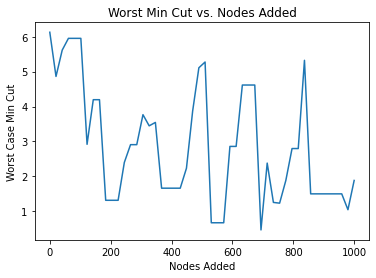

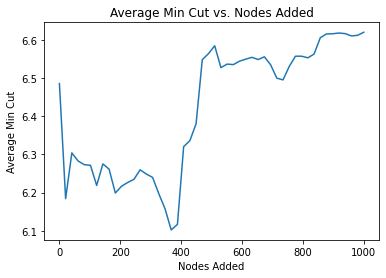

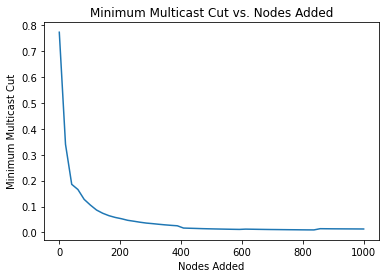

0.8691701578669923


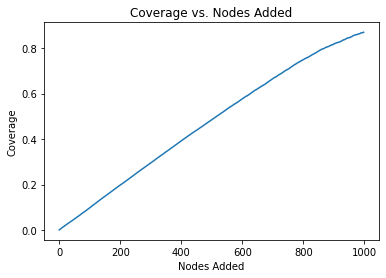

In [ ]:
# %% Results
print(len(worst))
print(len(ave))
print(len(mult))
print(len(cover))
x_axis = np.linspace(0,1000,50)

plt.plot(x_axis, worst)
plt.xlabel("Nodes Added")
plt.ylabel("Worst Case Min Cut")
plt.title("Worst Min Cut vs. Nodes Added")
plt.show()

plt.plot(x_axis, ave)
plt.xlabel("Nodes Added")
plt.ylabel("Average Min Cut")
plt.title("Average Min Cut vs. Nodes Added")
plt.show()

plt.plot(x_axis, mult)
plt.xlabel("Nodes Added")
plt.ylabel("Minimum Multicast Cut")
plt.title("Minimum Multicast Cut vs. Nodes Added")
plt.show()

plt.plot(cover)
print(cover[-1]) # Maximum coverage ratio at 1000 nodes
plt.xlabel("Nodes Added")
plt.ylabel("Coverage")
plt.title("Coverage vs. Nodes Added")
plt.show()

Answer: Our algorithm requires 1293 sensors, while uniform random placement requires 2419 sensors.